# PA005: High Value Customer Identification (Insiders)

## 0.0 Planejamento da solução (IOT)

### Input - Entrada

1. Problema de Negócio
    - Selecionar os clientes mais valiosos para integrar um programa de fidelização

2. Conjunto de dados
    - Vendas de um e-commerce durante o perído de um ano.

### Output - Saída

1. A indicação das pessoas que farão parte do programa de Insiders
    - Lista: client_id | is_insider
                2930   |   yes/1
                3492   |   no/1

2. Relatório com as respostas das perguntas de negócio
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?
                

### Task - Tarefas

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - O que é ser elegível? O que são clientes de maior "valor"?
    - Faturamento:
        - Alto Ticket médio. (média dos gastos na empresa)
        - Alto LTV. (Total gasto na empresa)
        - Baixa Recência. (intervalo entre as compras)
        - Alto basket size. (itens comprados de 1 vez) - Talvez seja redundante em relação às outras métricas
        - Baixa probabilidade de Churn. (chance de deixar de consumir produtos da empresa) -  Comum rodar um modelo de churn e           usar o resultado como coluna na clusterização
        - Alta previsão de LTV.
        - Alta propensão de compra.
        
    - Custo:
        - Baixa taxa de devolução.
        
    - Experiência:
        - Média alta das avaliações.
        
    
2. Quantos clientes farão parte do grupo?
    - Número total de clientes
    - % do grupo Insiders
    

3. Quais as principais características desses clientes?
    - Escrever características do cliente: 
        - Idade
        - Localização
        
    - Escrever características do consumo.
        - Atributos da clusterização. 
        

4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders?
    - Faturamento total do ano
    - Faturamento do grupo Insiders
    

5. Qual a expectativa de faturamento desse grupo para os próximos meses? (Ex: Assumir essa métrica no planejamento do orçamento da empresa)
    - LTV do grupo Insiders
    - Análise de Cohort. (Marcação em relação a algo e acompanhamento do desempenho)
    

6. Quais as condições para uma pessoa ser elegível ao Insiders?
    - Definir a periodicidade. (1 mês, 3 meses)
    - A pessoa precisa ser similar ou parecido com uma pessoa do grupo.

7. Quais as condições para uma pessoa ser removida do Insiders?
    - Definir a periodicidade. (1 mês, 3 meses)
    - A pessoa precisa ser desimilar ou não-parecido com uma pessoa do grupo.


8. Qual a garantia que o programa Insiders é melhor que o restante da base?
    - Teste A/B.
    - Teste A/B Bayesiano.
    - Teste de hipóteses.
     

9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Preferência de compra
    - Frete
    - Visita a empresa




## Benchmark de soluções
### 1. Desk Research

# 0.0 Imports

In [82]:
import inflection
import numpy   as np
import pandas  as pd
import seaborn as sns
import umap.umap_ as umap

from matplotlib import pyplot as plt
from IPython.display import HTML

from sklearn import cluster as c
from sklearn import metrics as m

from plotly import express as px

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Load dataset

In [3]:
#load data
df = pd.read_csv('data/Ecommerce.csv', encoding='unicode_escape')

#drop extra column
df = df.drop(columns=['Unnamed: 8'], axis=1)

In [4]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

# 1.0 Descrição dos dados

In [4]:
df1 = df.copy()

## 1.1 Rename Columns

In [5]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
            'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [6]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 541909
Number of Columns: 8


## 1.3 Data Types

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [8]:
# invoice_no são números. Como está dando object, deve haver algum caractere em algum lugar
# Usar o código abaixo para descobrir onde está;

#df1['invoice_no'] = df1['invoice_no'].astype(int)

## 1.4 Check NA

In [9]:
df1.isnull().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [10]:
df1 = df1.dropna(subset=['description', 'customer_id'])
print('Removed data: {:.2f}'.format(1 - (df1.shape[0] / df.shape[0])))

Removed data: 0.25


## 1.6 Change Dtypes

In [11]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


In [12]:
#invoice_no e stock_code serão analisados posteriormente

#invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

#customer_id
df1['customer_id'] = df1['customer_id'].astype('int64')

In [13]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 1.7 Descriptive Statistics

In [14]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [15]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#Concatenar
m1 = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m1.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m1

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


### <font color='red'>1.7.1.1 Numerical Attributes - Investigating </font>

1. Quantity negativa (pode ser devolução)

2. Preço unitário igual a zero (pode ser promoção?)


### 1.7.2 Categorical Attributes

In [16]:
#invoice_no

#cat_attributes['invoice_no'].astype(int) - #Algumas strings entre os números
#len(cat_attributes.loc[cat_attributes['invoice_no'].apply(lambda x: bool(re.search( '[^0-9]+', x ))), 'invoice_no'].drop_duplicates())

df_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search( '[^0-9]+', x ))), :]

print('Total number of invoices: {}'.format(len(df_invoices)))
print('Total number of negative quantity: {}'.format(len(df_invoices[df_invoices['quantity'] < 0])))

Total number of invoices: 8905
Total number of negative quantity: 8905


In [17]:
#stock_code
#aux = len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search( '[^0-9]+', x))), 'stock_code'].drop_duplicates())

cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search( '^[a-zA-Z]+$', x))), 'stock_code'].unique()
#df1.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search( '^[a-zA-Z]$', x ))), :].head()

#Ação:
## 1. Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

### Description

In [ ]:
df1.head()

#Ação: Delete description

### Country

In [22]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

In [19]:
df1['country'].value_counts(normalize=True).head()

United Kingdom    0.889509
Germany           0.023339
France            0.020871
EIRE              0.018398
Spain             0.006226
Name: country, dtype: float64

In [20]:
#Drop_duplicates é usado quando quero saber o número de usuários únicos. Sem o drop a granularidade é por compra. Ex: 1 usuário pode ter feito 10 compras
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()

,country,customer_id
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25


# 3.0 Filtragem de Variáveis

- Nesse caso a filtragem se fez necessária antes do passo 2 pq no passo 2 são feitos cálculos pra criar as variáveis, logo, n pode haver sujeira. Isso justifica adiantar o passo 3

In [56]:
df3 = df1.copy()

In [57]:
# Numerical Attributes

## Separar entre dados com devoluções e sem devoluções
df3 = df3.loc[df3['unit_price'] >= 0.04, :]


# -- Categorical Attributes --

#isin pq fica mais fácil já que é uma lista | ~ (usado com o isin) pq vou pegar oq não estiver contido na condição
df3 = df3[~df3['stock_code'].isin(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'])] 

#description
df3 = df3.drop(columns='description', axis=1)

#map 
df3 = df3[~df3['country'].isin(['European Community', 'Unspecified'])]

#quantity
df3_charge_back = df3.loc[df3['quantity'] < 0, :]
df3_purchases = df3.loc[df3['quantity'] >= 0, :]


In [42]:
df3.loc[df3['unit_price'] > 0.04 , ['customer_id', 'description', 'unit_price']].sort_values('unit_price', ascending=True).head(10)

,customer_id,description,unit_price
275044,15829,HOUSE SHAPE PENCIL SHARPENER,0.06
485986,16406,LETTER SHAPE PENCIL SHARPENER,0.06
241329,14298,CARTOON PENCIL SHARPENERS,0.06
218247,15159,HOUSE SHAPE PENCIL SHARPENER,0.06
498510,17254,CARTOON PENCIL SHARPENERS,0.06
218246,15159,CARTOON PENCIL SHARPENERS,0.06
422266,17545,CARTOON PENCIL SHARPENERS,0.06
359033,16931,LETTER SHAPE PENCIL SHARPENER,0.06
498270,14591,CARTOON PENCIL SHARPENERS,0.06
476270,16869,LETTER SHAPE PENCIL SHARPENER,0.06


# 2.0 Feature Engeneering

In [58]:
df2 = df3.copy()

## 2.1 Feature Creation

In [59]:
# data reference
df_ref = df2.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date',
                   'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

- Ficar atento pq Meiga não usou o purchases pra fazer o df_ref

In [60]:
#Gross Revenue (Faturamento) quantity * price
df3_purchases.loc[:, 'gross_revenue'] = df3_purchases.loc[:, 'quantity'] * df3_purchases.loc[:, 'unit_price']

#Monetary
df_monetary = df3_purchases.loc[: ,['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')


C:\Users\Ed\AppData\Local\Temp\ipykernel_9992\2394746934.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_purchases.loc[:, 'gross_revenue'] = df3_purchases.loc[:, 'quantity'] * df3_purchases.loc[:, 'unit_price']


In [63]:
#Recency - Last day purchase - Como o dataset é antigo, usar como date o último invoice_date
df_recency = df3_purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index() # Agrupa por usuários e pega a data máxima da última compra de cada
df_recency['recency_days'] = (df3_purchases['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

In [66]:
#Frequency
df_frequency = df3_purchases[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index() 
df_frequency = df_frequency.rename(columns={'invoice_no': 'frequency'}) 
df_ref = pd.merge(df_ref, df_frequency, on='customer_id', how='left')


In [68]:
#AVG Ticket
df_avg_ticket = df3_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left') #Sempre calcular os NA's depois do left join

In [69]:
df_ref.isnull().sum()

customer_id       0
gross_revenue    27
recency_days     27
frequency        27
avg_ticket       27
dtype: int64

In [70]:
df_ref.head()

,customer_id,gross_revenue,recency_days,frequency,avg_ticket
0,17850,5391.21,372.0,34.0,18.152222
1,13047,3232.59,56.0,9.0,18.904035
2,12583,6705.38,2.0,15.0,28.902500
3,13748,948.25,95.0,5.0,33.866071
4,15100,876.00,333.0,3.0,292.000000


In [36]:
# #Gross Revenue (Faturamento) quantity * price
# df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

# #Monetary
# df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
# df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

# #Recency - Last day purchase - Como o dataset é antigo, usar como date o último invoice_date
# df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index() # Agrupa por usuários e pega a data máxima da última compra de cada
# df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
# df_recency = df_recency[['customer_id', 'recency_days']].copy()
# df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

# #Frequency
# df_frequency = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index() 
# df_frequency = df_frequency.rename(columns={'invoice_no': 'frequency'}) 
# df_ref = pd.merge(df_ref, df_frequency, on='customer_id', how='left')

# #AVG Ticket
# df_avg_ticket = df2[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
# df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left') #Sempre calcular os NA's depois do left join

In [18]:
df_ref.head()

,customer_id,gross_revenue,recency_days,frequency,avg_ticket
0,17850,5288.63,302,35,16.950737
1,13047,3079.10,31,18,15.709694
2,12583,7187.34,2,18,28.634821
3,13748,948.25,95,5,33.866071
4,15100,635.10,330,6,105.850000


# 4.0 EDA (Exploratory Data Analysis)

In [71]:
df4 = df_ref.dropna()
df4.isnull().sum()

customer_id      0
gross_revenue    0
recency_days     0
frequency        0
avg_ticket       0
dtype: int64

# 5.0 Data Preparation

In [72]:
df5 = df4.copy()

# 6.0 Feature Selection

In [73]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine-Tunning

In [74]:
df7 = df6.drop(columns=['customer_id'])

In [75]:
df7.head()

,gross_revenue,recency_days,frequency,avg_ticket
0,5391.21,372.0,34.0,18.152222
1,3232.59,56.0,9.0,18.904035
2,6705.38,2.0,15.0,28.902500
3,948.25,95.0,5.0,33.866071
4,876.00,333.0,3.0,292.000000


In [76]:
clusters = [2,3,4,5,6,7]

## 7.1 Within-Cluster Sum of Square (WSS)

In [ ]:
wss = []
for k in clusters:
    #model definition
    kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    
    #model training
    kmeans.fit(df7)
    
    #validation
    wss.append(kmeans.inertia_)
    
# plot wss - Elbow Method - Pegar o ponto onde houver maior variação, quebra (3 ou 5) Isso significa que após esses pontos a variação de distancia dentro dos clusteres n está diminuindo muito, então n é o ideal
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Within-Cluster Sum of Square');
plt.title('WSS vs K');

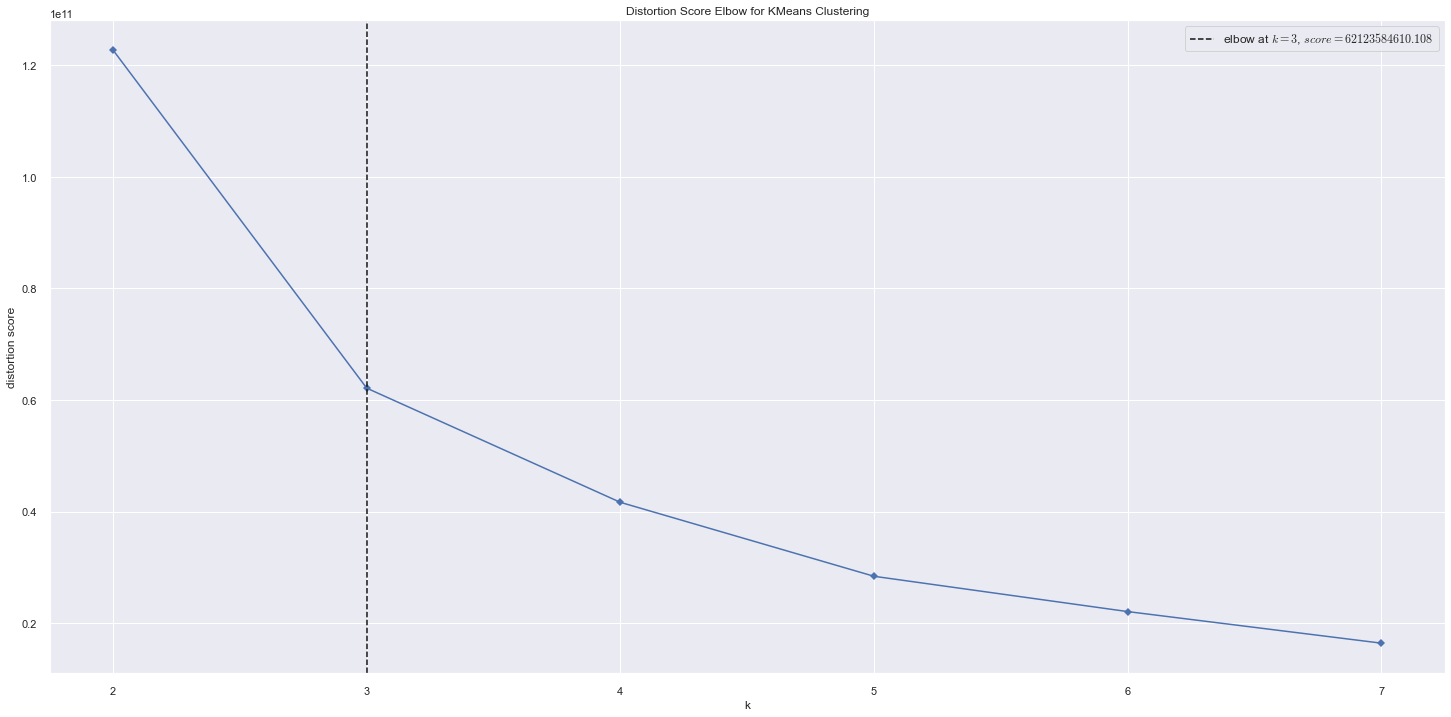

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [77]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit(df7)
kmeans.show()

## 7.2 Sillhouette Score (SS)

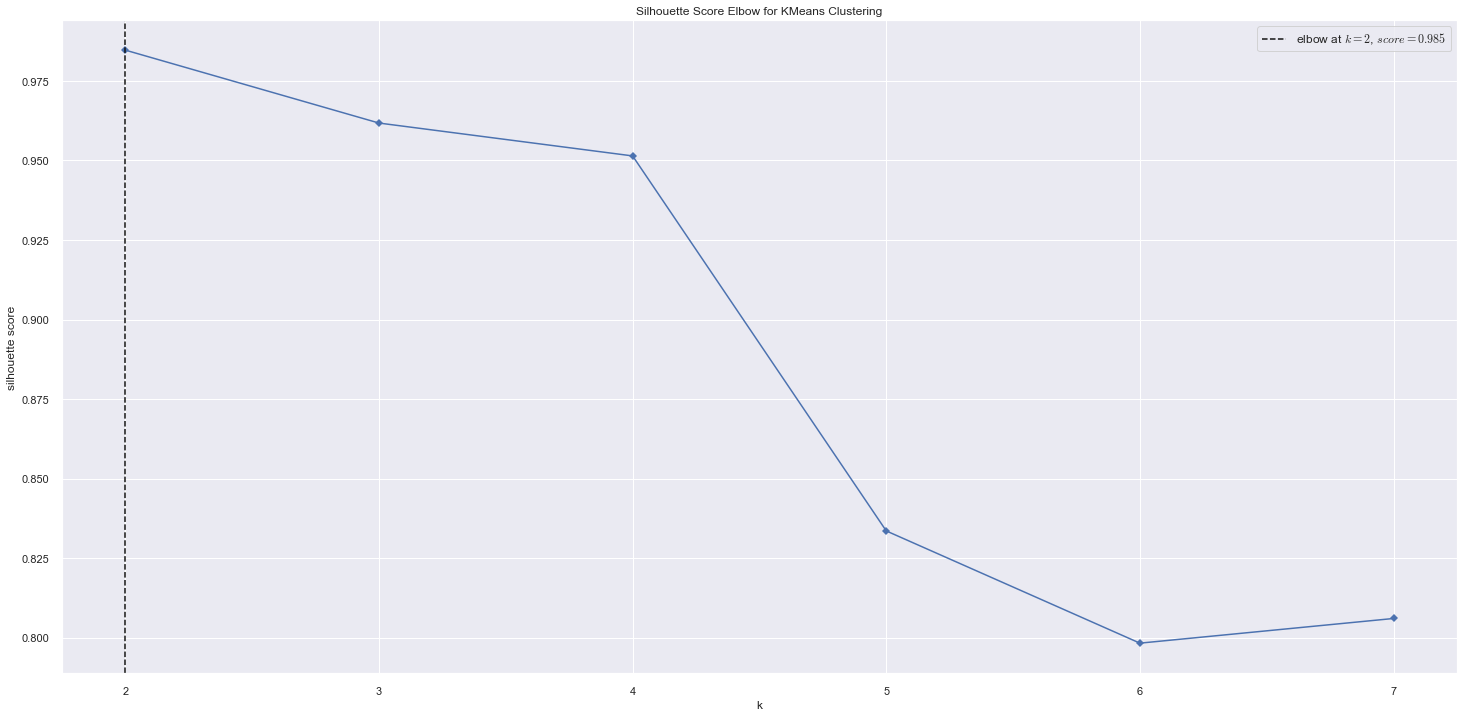

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [78]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit(df7)
kmeans.show()

## 7.3 Silhouette Analysis

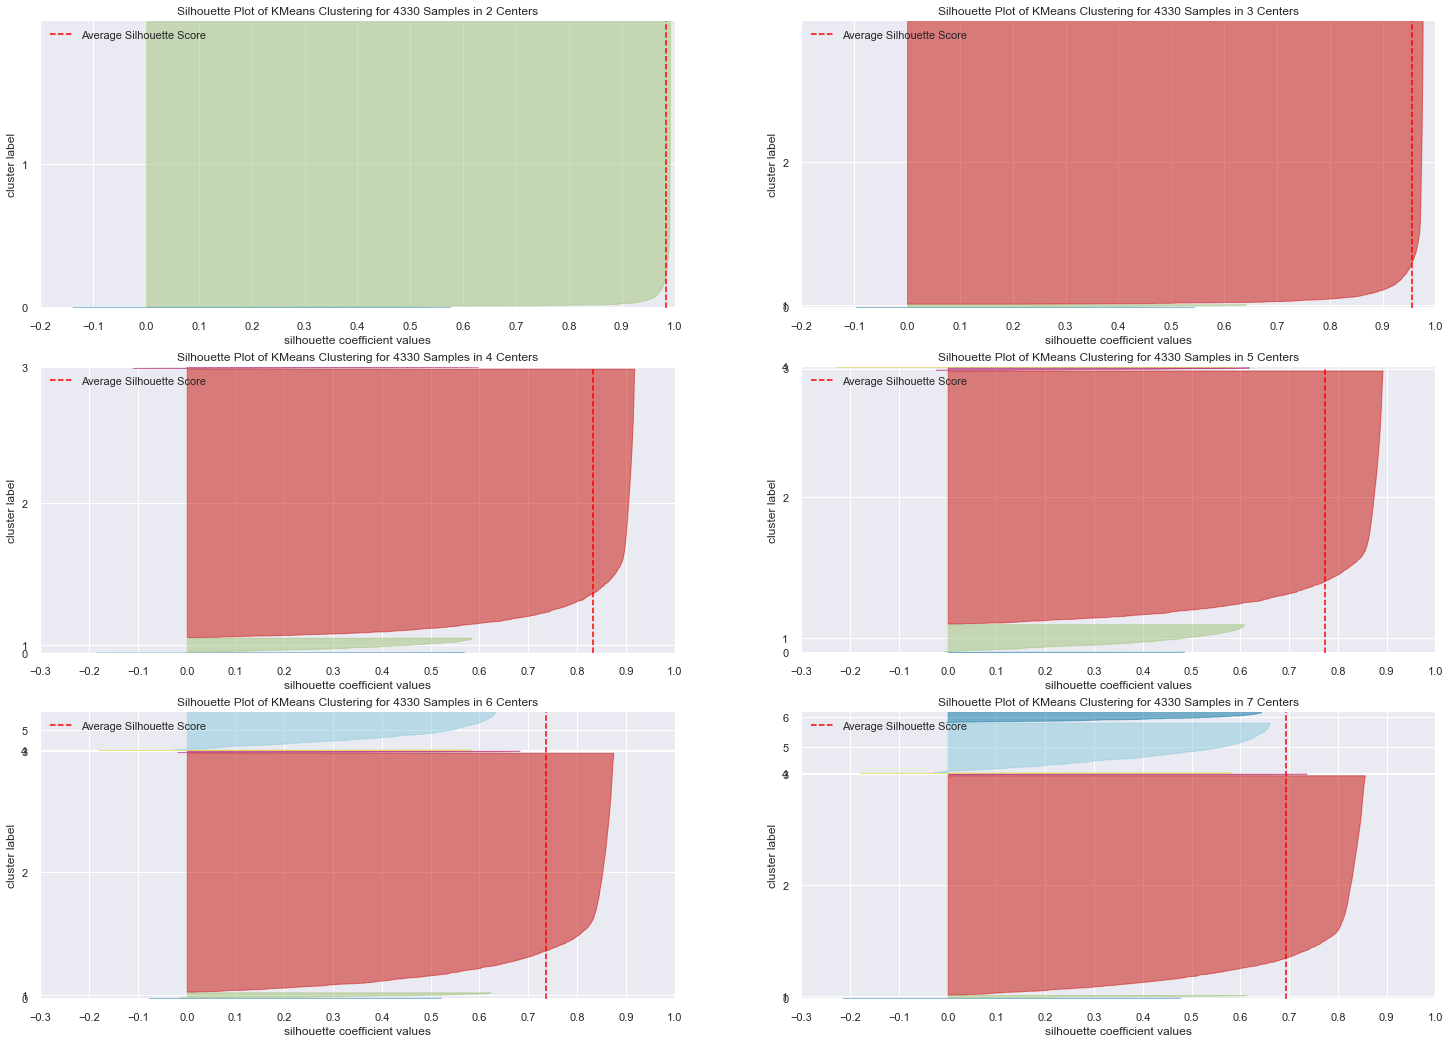

In [79]:
fig, ax = plt.subplots(3, 2, figsize=(25, 18))

for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2) #Para poder plotar os gráficos. O valor é de acordo com o k mínimo
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df7)
    visualizer.finalize()

In [43]:
df7.head()

,gross_revenue,recency_days,frequency,avg_ticket
0,5288.63,302,35,16.950737
1,3079.10,31,18,15.709694
2,7187.34,2,18,28.634821
3,948.25,95,5,33.866071
4,635.10,330,6,105.850000


# 8.0 Model Training

## 8.1 K-Means

In [80]:
#model definition
k=5
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

#model training
kmeans.fit(df7)

#clustering
labels = kmeans.labels_


### 8.2 Cluster Validation

In [83]:
#WSS
print('WSS value: {}'.format(kmeans.inertia_))

#SS
print(m.silhouette_score(df7, labels, metric='euclidean'))

WSS value: 37802566787.37713
0.7732515336579786


# 9.0 Cluster Analysis

In [85]:
df9 = df4.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,frequency,avg_ticket,cluster
0,17850,5391.21,372.0,34.0,18.152222,1
1,13047,3232.59,56.0,9.0,18.904035,2
2,12583,6705.38,2.0,15.0,28.902500,1
3,13748,948.25,95.0,5.0,33.866071,2
4,15100,876.00,333.0,3.0,292.000000,2


## 9.1 Visualization Inspection

C:\Users\Ed\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


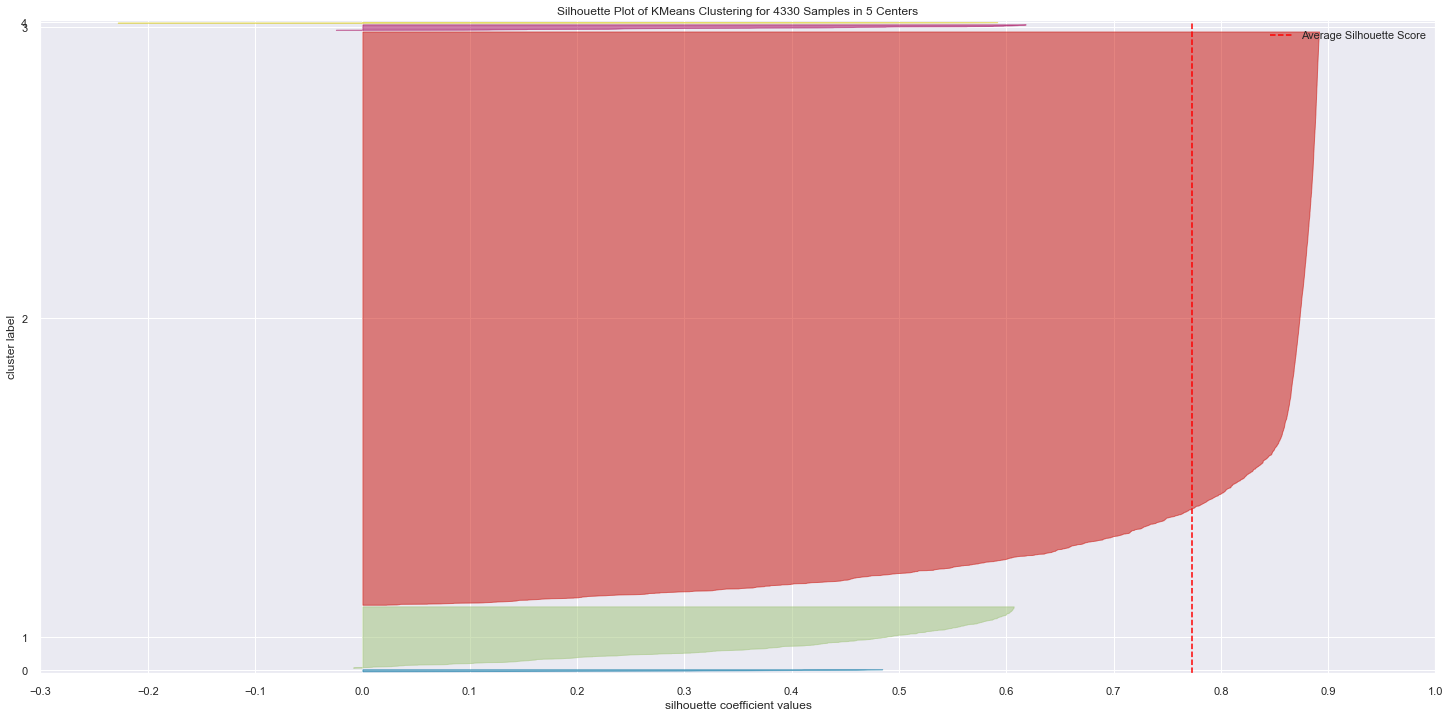

In [86]:
#fig = px.scatter_3d(df9, x='recency_days', y='frequency', z='gross_revenue', color='cluster')
#fig.show()

visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(df7)
visualizer.finalize()

## 9.3 2d plot

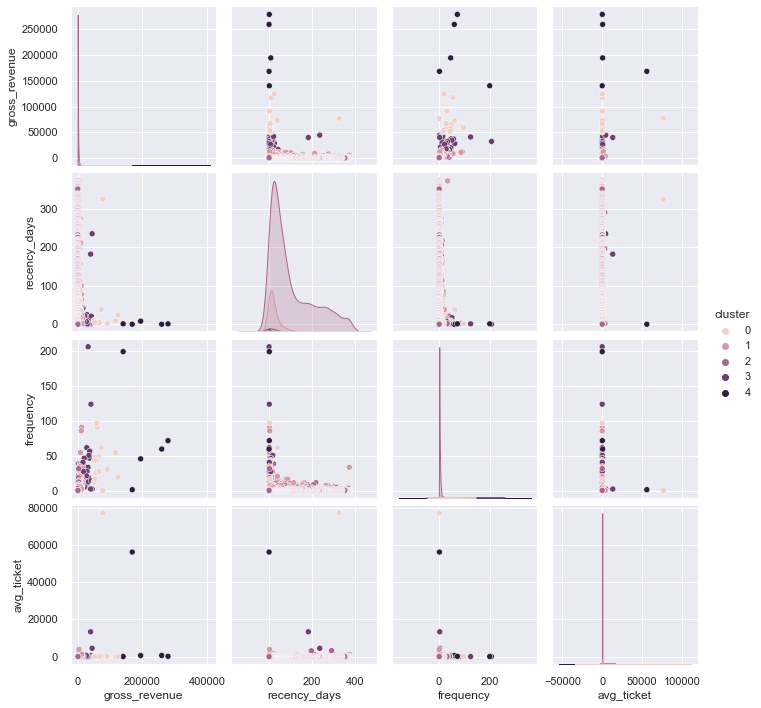

In [87]:
df_viz = df9.drop(columns='customer_id', axis = 1)
sns.pairplot(df_viz, hue='cluster')

## 9.3 UMAP - t-SNE

#PCA - Matrix, Espaço de Distância - Espaço Hilbert - 9 condições - Colorários
#UMAP, t-SNE - Manifold - Topologia - Ferramentas que fazem a projeção de alta dimensão para baixa dimensão.




<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

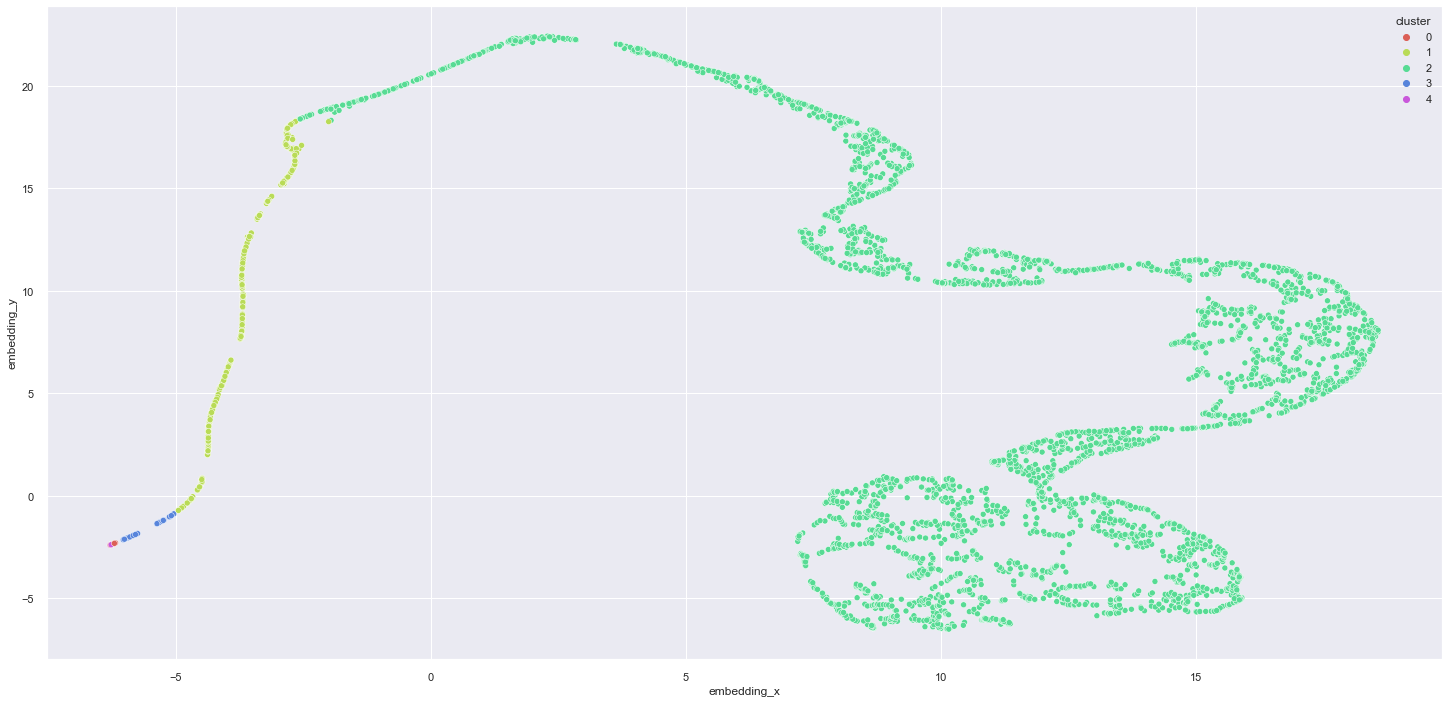

In [88]:
reducer = umap.UMAP(random_state=42) #UMAP é melhor para muitos dados pq executa mais rápido. t-SNE é mais robusto, tem melhor resultado, mas demora.
embedding = reducer.fit_transform(df7)

#embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y',
                hue='cluster',
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                data=df_viz)

#Os pontos próximos devem ter a mesma cor
#Encontra a similaridade entre os vizinhos e faz a projeção num espaço menor

In [32]:
df9.head()

,customer_id,gross_revenue,recency_days,frequency,avg_ticket,cluster
0,17850,5288.63,302,35,16.950737,3
1,13047,3079.10,31,18,15.709694,0
2,12583,7187.34,2,18,28.634821,3
3,13748,948.25,95,5,33.866071,0
4,15100,635.10,330,6,105.850000,0


## 9.4 Cluster Profile

In [89]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

#AVG Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

#AVG Recency
df_avg_recency = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency, how='inner', on='cluster')

#AVG Frequency
df_avg_frequency = df9[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_frequency, how='inner', on='cluster')

#AVG_Ticket
df_avg_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_ticket, how='inner', on='cluster')


In [90]:
df_cluster.head()

,cluster,customer_id,perc_customer,gross_revenue,recency_days,frequency,avg_ticket
0,0,15,0.346420,70563.601333,29.333333,41.800000,5319.257814
1,1,413,9.538106,5932.363584,26.193705,12.377724,60.568214
2,2,3859,89.122402,843.890329,100.341798,2.847370,28.490561
3,3,38,0.877598,25177.080000,17.789474,34.184211,585.440059
4,4,5,0.115473,208453.866000,2.000000,75.800000,11499.503365


### Cluster 01: (Candidato à Insider)
    - Número de customers: 6 (0.2% dos customers)
    - Recência em média: 7 dias
    - Compras em média: 89 compras
    - Receita em média: $182.182,00 dólares
        
### Cluster 02: 
    - Número de customers: 31 (0.8% dos customers)
    - Recência em média: 14 dias
    - Compras em média:53 compras
    - Receita em média: $40.543,52 dólares
        
### Cluster 03: 
    - Número de customers: 4.335 (99% dos customers)
    - Recência em média: 92 dias
    - Compras em média:5 compras
    - Receita em média: $1.372,57 dólares

# 10.0 Deploy To Production